### H1: Overall ISC and ISC within regions involved in mentalizing/mentalizing-network

#### Import modules

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, nilearn, pickle
from nilearn import plotting, input_data, datasets
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from utils import *
import warnings
warnings.simplefilter("ignore")

#### Load timeseries, run basic ISC (static)

In [8]:
# load timeseries, swap axes
ts_array = np.load('../data/ts_array_shen268_regional_average_ages13-99.npy')
ts_data = np.swapaxes(ts_array, 0, 2)
ts_data = np.swapaxes(ts_data, 0, 1)

# submit to ISC analysis
ISC, p, distribution = partly_phaseshift_isc(ts_data, 
                                           pairwise= False,
                                           summary_statistic = np.mean,
                                           n_shifts = 1000, #can reduce to speed up, better increase to 1000
                                           return_distribution=True)

ISC[np.isnan(ISC)] = 0

# Stats correction (uncomment if you computed enough n_shifts)
alpha                           = .05
q                               = multipletests(p[0, :], method='fdr_by')[1]
corrected                       = q[np.newaxis, :] < alpha
ISC[corrected == False]         = 0

isc_result_dict                 = {}
isc_result_dict['ISC']          = ISC
isc_result_dict['p']            = p
isc_result_dict['distribution'] = distribution

#### Plot ISC results

<Figure size 1440x1080 with 0 Axes>

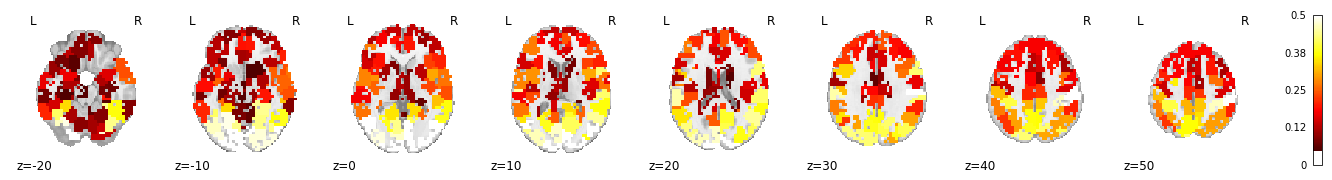

In [10]:
shen_file = '../data/maps/shen_2mm_268_parcellation.nii';

labels_masker = input_data.NiftiLabelsMasker(shen_file);
dataset = datasets.fetch_development_fmri(n_subjects = 1);
labels_masker.fit_transform(dataset.func[0]);

curr_isc = np.reshape(ISC, (268,1)).T
curr_img = labels_masker.inverse_transform(curr_isc);
plt.figure(figsize = (20,15));
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                   threshold    = 0.05, 
                                   vmax         = 0.5, 
                                   draw_cross   = True,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20,  30, 40, 50],
                                   annotate     = True,);
plt.show();

#### Assess maxima, ISC in mentalizing regions

In [16]:
max_isc_index = np.where(ISC.T == np.nanmax(ISC.T))[0][0]
print(max_isc_index)
print(ISC[0,max_isc_index])
print(isc_result_dict['p'][0][max_isc_index])

213
0.5500237411721413
0.000999000999000999


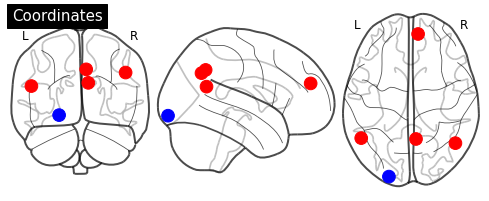

,Adults_ISC,index,coords
9_10_48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus,0.244901,9,"[8.521081081081078, 53.28, 23.885405405405407]"
47_48_66.63% Lateral_Occipital_Cortex_superior_division; 33.37% Angular_Gyrus,0.300894,47,"[47.79274611398964, -61.56476683937824, 34.712..."
89_90_83.65% Precuneous_Cortex; 16.35% Cingulate_Gyrus_posterior_division,0.374103,89,"[6.3299270072992755, -57.185401459854006, 38.0..."
182_183_54.25% Angular_Gyrus; 17.20% Lateral_Occipital_Cortex_superior_division; 16.45% Supramarginal_Gyrus_posterior_division; 8.92% Middle_Temporal_Gyrus_temporooccipital_part,0.352999,182,"[-51.31847133757961, -56.269639065817415, 20.4..."
213_214_87.06% Occipital_Pole; 8.47% Lateral_Occipital_Cortex_inferior_division,0.550024,213,"[-22.170015455950534, -96.75115919629057, -10...."


In [17]:
selected_regions = [47, 182, 9, 89, 213 ] 
#These regions are selected because they are part of the DMN (plus the visual cortex where ISC was max)

# load dictionary that contains information about the Shen-parcellation
shen_dictionary = np.load('../data/maps/shen_dictionary.npy', allow_pickle = True).item()
names_list      = []
coords_list     = []

for i in np.arange(268):
    names_list.append(str(i) + '_' + str(i+1) + '_' + shen_dictionary[i+1]['name']) 
    coords_list.append(shen_dictionary[i+1]['coords'])
    
# plot the selected regions    
networks_coords = np.asarray(coords_list)[selected_regions]
n_nodes = len(networks_coords)
plotting.plot_connectome(np.zeros((n_nodes,n_nodes)), 
                         networks_coords, 
                         title = 'Coordinates',
                         node_color = ['red', 'red', 'red', 'red', 'blue'],
                         node_size = 160);
plt.show()

# print a descriptive table
pd.set_option('display.max_rows', 268)
df            = pd.DataFrame(ISC.T, columns = ['Adults_ISC'], index = names_list)
df['index']   = np.arange(268)
df['coords']  = coords_list
df[df['index'].isin(selected_regions)]


In [20]:
# if you've properly permuted the results, can uncomment to look at significance
isc_result_dict['p'][0][selected_regions]

array([0.000999, 0.000999, 0.000999, 0.000999, 0.000999])

### ISC across mentalizing-network as whole 
i.e. based on network-averaged data.

In [19]:
# load data, reorder axis
ts_array = np.load('../data/ts_array_mentalizingfine_regional_average_ages13-99.npy')
print(ts_array.shape)

ts_data = np.swapaxes(ts_array, 0, 2)
ts_data = np.swapaxes(ts_data, 0, 1)
print(ts_data.shape)

# compute ISC
ISC, p, distribution = partly_phaseshift_isc(ts_data, 
                                           #pairwise=True, #can use pairwise or ind2group
                                           summary_statistic=np.mean,
                                           n_shifts = 1000, #can reduce to speed up, better increase to 1000
                                           return_distribution=True)

ISC[np.isnan(ISC)] = 0

# Stats
alpha                   = .05
q                       = multipletests(p[0, :], method='fdr_bh')[1]
corrected               = q[np.newaxis, :] < alpha
ISC[corrected == False] = 0

print('ISC: ' + str(ISC[0]) + ' q:' + str(q))

(33, 168, 1)
(168, 1, 33)
ISC: [0.29515191] q:[0.000999]
